# Tourist Housing - Barcelona

## Initial Module Imports and File Loads
In this section, we load in various python modules and load in our data files. 

### Import python modules

These modules will help us create graphics and work with dataframes and geodataframes. 

In [1]:
# Import geopandas
import geopandas as gpd

# and regular pandas
import pandas as pd

# to provide basemaps 
import contextily as ctx

# to give more power to your figures (plots)
import matplotlib.pyplot as plt

# for interactive maps
import plotly.express as px

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Load in barri geojson file 
bb = gpd.read_file('Data/shapefiles_barrio_barcelona.geojson')

In [3]:
# Load in data files
ab_16 = gpd.read_file('Data/AirBNB_2016.csv')
ab_17 = gpd.read_file('Data/AirBNB_2017.csv')
ab_18 = gpd.read_file('Data/AirBNB_2018.csv')
ab_19 = gpd.read_file('Data/AirBNB_2019.csv')
ab_20 = gpd.read_file('Data/AirBNB_2020.csv')

In [4]:
# Load in overall housing csv file
housing = gpd.read_file('Data/2010_2020_TotalHousing_Barri.csv')

## Data Clean Up

### Clean up data file #1: barri spatial data

We've worked with this dataframe before. It needs to be trimmed to only include the columns: c_barri, n_barri, and geometry.  

In [5]:
# Trim the dataframe so that we just have the number of the neighborhood, name of the neighborhood (for backchecking),
# and the geometry. Print the first 5 rows to test. 

bb_tr = bb[['c_barri','n_barri','geometry']]
bb_tr.head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4       12             la Marina del Prat Vermell   

                                            geometry  
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  
4  MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3...

### Clean up data file #2-5: Airbnb data

We'll want to trim this data to just get geocoordinates, id, room_type, and geometry. 

In [ ]:
ab_20.head()

In [ ]:
ab_20.tail()

In [ ]:
#Check the first five rows
ab_16.head()

In [ ]:
#Check the last five rows
ab_16.tail()

In [6]:
#Check how many rows of data we have
ab_16.shape

(14855, 17)

In [7]:
#Convert lat and long columns into geometry column
ab_16 = gpd.GeoDataFrame(
    ab_16, geometry=gpd.points_from_xy(ab_16.longitude, ab_16.latitude))
ab_17 = gpd.GeoDataFrame(
    ab_17, geometry=gpd.points_from_xy(ab_17.longitude, ab_17.latitude))
ab_18 = gpd.GeoDataFrame(
    ab_18, geometry=gpd.points_from_xy(ab_18.longitude, ab_18.latitude))
ab_19 = gpd.GeoDataFrame(
    ab_19, geometry=gpd.points_from_xy(ab_19.longitude, ab_19.latitude))
ab_20 = gpd.GeoDataFrame(
    ab_20, geometry=gpd.points_from_xy(ab_20.longitude, ab_20.latitude))

In [8]:
#Trim dataframes
columns_to_keep = ['id','neighbourhood','room_type','geometry']
ab_16_pt = ab_16[columns_to_keep]
ab_17_pt = ab_17[columns_to_keep]
ab_18_pt = ab_18[columns_to_keep]
ab_19_pt = ab_19[columns_to_keep]
ab_20_pt = ab_20[columns_to_keep]

In [ ]:
ab_16_pt.head()

We'll keep these dataframes as our point geometry, but next we'll group them in order to get counts per barri.

In [9]:
ab_16_pt.room_type.value_counts()

Entire home/apt    7871
Private room       6828
Shared room         156
Name: room_type, dtype: int64

It will be important to consider counts for entire home/apt and private room or shared room, since these represent how many housing units are taken off the market. Note: It's possible that multiple private rooms could be rented out within the same entire apartment. 

### Normalize Airbnb Data with Total Housing Data per Barri

Here we'll combine our airbnb data and total housing per barri data in order to obtain normalized airbnb data. We only grabbed the data for "Entire home/apt" to see the number of units completely taken off the market. 

In [10]:
#create function to count airbnb units by barri
def countbnb(df):
    a=df[df.room_type == 'Entire home/apt']
    b=a.neighbourhood.value_counts().rename_axis('neighbourhood').reset_index(name='ab_count')
    return b

def countbnb_t(df):
    #a=df[df.room_type == 'Entire home/apt']
    b=df.neighbourhood.value_counts().rename_axis('neighbourhood').reset_index(name='ab_count')
    return b

In [11]:
#create df of entire home count by barri for each year
eh16=countbnb(ab_16_pt)
eh17=countbnb(ab_17_pt)
eh18=countbnb(ab_18_pt)
eh19=countbnb(ab_19_pt)
eh20=countbnb(ab_20_pt)

tot16=countbnb_t(ab_16_pt)
tot17=countbnb_t(ab_17_pt)
tot18=countbnb_t(ab_18_pt)
tot19=countbnb_t(ab_19_pt)
tot20=countbnb_t(ab_20_pt)

In [12]:
eh16.head()

neighbourhood  ab_count
0                 la Dreta de l'Eixample       878
1                      la Vila de Gràcia       615
2                               el Raval       590
3  Sant Pere, Santa Caterina i la Ribera       557
4                           el Poble Sec       515

In [13]:
tot16.head()

neighbourhood  ab_count
0                 la Dreta de l'Eixample      1342
1                               el Raval      1223
2                         el Barri Gòtic      1035
3                      la Vila de Gràcia      1010
4  Sant Pere, Santa Caterina i la Ribera       992

In [14]:
#rename the ab_count column for the specific year
eh16.columns = ['n_barri', '2016']
eh17.columns = ['n_barri', '2017']
eh18.columns = ['n_barri', '2018']
eh19.columns = ['n_barri', '2019']
eh20.columns = ['n_barri', '2020']

tot16.columns = ['n_barri', '2016']
tot17.columns = ['n_barri', '2017']
tot18.columns = ['n_barri', '2018']
tot19.columns = ['n_barri', '2019']
tot20.columns = ['n_barri', '2020']

In [15]:
#merge into one df
abeh = eh16.merge(
    eh17.merge(
        eh18.merge(
            eh19.merge(
                eh20, on='n_barri'),on='n_barri'),on='n_barri'),on='n_barri')

abtot = tot16.merge(
    tot17.merge(
        tot18.merge(
            tot19.merge(
                tot20, on='n_barri'),on='n_barri'),on='n_barri'),on='n_barri')

In [16]:
#rename the columns for abeh
abeh.columns=['n_barri','bnb_2016','bnb_2017','bnb_2018','bnb_2019','bnb_2020']
abtot.columns=['n_barri','bnb_2016','bnb_2017','bnb_2018','bnb_2019','bnb_2020']

In [17]:
#reset header
housing.columns = housing.iloc[0]
housing = housing.drop(housing.index[0])

In [18]:
housing.head()

0 c_barri                     n_barri   2010   2011   2012   2013   2014  \
1       1                    el Raval  23284  23279  23342  23446  23409   
2      10                 Sant Antoni  20137  20215  20200  20234  20255   
3      11                el Poble Sec  19202  19145  19159  19196  19178   
4      12  la Marina del Prat Vermell    893    893    881    906    744   
5      13           la Marina de Port  12818  12950  13153  13157  13103   

0   2015   2016   2017   2018   2019   2020   NaN  
1  23432  23444  23454  23112  23112  23202  None  
2  20271  20281  20264  19484  19484  19488  None  
3  19189  19216  19228  18520  18520  18569  None  
4    798    798    798    776    776    776  None  
5  13154  13277  13277  13315  13334  13335  None

In [19]:
#trim to only have years needed
housing=housing[['c_barri','n_barri','2016','2017','2018','2019','2020']]

In [20]:
#rename columns for housing dataframe
housing.columns=['c_barri','n_barri','tot_2016','tot_2017','tot_2018','tot_2019','tot_2020']

In [21]:
#merge housing and grouped airbnb data
final_eh = housing.merge(abeh, on='n_barri')
final_tot = housing.merge(abtot, on='n_barri')

In [22]:
#Convert total housing data to integer type
final_eh['c_barri'] = final_eh['c_barri'].astype(int)
final_eh['tot_2016'] = final_eh['tot_2016'].astype(int)
final_eh['tot_2017'] = final_eh['tot_2017'].astype(int) 
final_eh['tot_2018'] = final_eh['tot_2018'].astype(int) 
final_eh['tot_2019'] = final_eh['tot_2019'].astype(int) 
final_eh['tot_2020'] = final_eh['tot_2020'].astype(int) 

final_tot['c_barri'] = final_tot['c_barri'].astype(int)
final_tot['tot_2016'] = final_tot['tot_2016'].astype(int)
final_tot['tot_2017'] = final_tot['tot_2017'].astype(int) 
final_tot['tot_2018'] = final_tot['tot_2018'].astype(int) 
final_tot['tot_2019'] = final_tot['tot_2019'].astype(int) 
final_tot['tot_2020'] = final_tot['tot_2020'].astype(int) 

In [23]:
#Add a column for the normalized data: number of airbnb units per 1000 dwellings
final_eh['bnb16_per_1000'] = final_eh['bnb_2016']/final_eh['tot_2016']*1000
final_eh['bnb17_per_1000'] = final_eh['bnb_2017']/final_eh['tot_2017']*1000
final_eh['bnb18_per_1000'] = final_eh['bnb_2018']/final_eh['tot_2018']*1000
final_eh['bnb19_per_1000'] = final_eh['bnb_2019']/final_eh['tot_2019']*1000
final_eh['bnb20_per_1000'] = final_eh['bnb_2020']/final_eh['tot_2020']*1000

final_eh['bnb16-17 % Change'] = (final_eh['bnb_2017']-final_eh['bnb_2016'])/final_eh['bnb_2016']*100
final_eh['bnb17-18 % Change'] = (final_eh['bnb_2018']-final_eh['bnb_2017'])/final_eh['bnb_2017']*100
final_eh['bnb18-19 % Change'] = (final_eh['bnb_2019']-final_eh['bnb_2018'])/final_eh['bnb_2018']*100
final_eh['bnb19-20 % Change'] = (final_eh['bnb_2020']-final_eh['bnb_2019'])/final_eh['bnb_2019']*100

final_tot['bnb16_per_1000'] = final_tot['bnb_2016']/final_tot['tot_2016']*1000
final_tot['bnb17_per_1000'] = final_tot['bnb_2017']/final_tot['tot_2017']*1000
final_tot['bnb18_per_1000'] = final_tot['bnb_2018']/final_tot['tot_2018']*1000
final_tot['bnb19_per_1000'] = final_tot['bnb_2019']/final_tot['tot_2019']*1000
final_tot['bnb20_per_1000'] = final_tot['bnb_2020']/final_tot['tot_2020']*1000

final_tot['bnb16-17 % Change'] = (final_tot['bnb_2017']-final_tot['bnb_2016'])/final_tot['bnb_2016']*100
final_tot['bnb17-18 % Change'] = (final_tot['bnb_2018']-final_tot['bnb_2017'])/final_tot['bnb_2017']*100
final_tot['bnb18-19 % Change'] = (final_tot['bnb_2019']-final_tot['bnb_2018'])/final_tot['bnb_2018']*100
final_tot['bnb19-20 % Change'] = (final_tot['bnb_2020']-final_tot['bnb_2019'])/final_tot['bnb_2019']*100

In [24]:
final_eh.head()

c_barri                     n_barri  tot_2016  tot_2017  tot_2018  \
0        1                    el Raval     23444     23454     23112   
1       10                 Sant Antoni     20281     20264     19484   
2       11                el Poble Sec     19216     19228     18520   
3       12  la Marina del Prat Vermell       798       798       776   
4       13           la Marina de Port     13277     13277     13315   

   tot_2019  tot_2020  bnb_2016  bnb_2017  bnb_2018  ...  bnb_2020  \
0     23112     23202       590       666       626  ...       747   
1     19484     19488       394       433       458  ...       469   
2     18520     18569       515       515       487  ...       587   
3       776       776         3         3         7  ...         7   
4     13334     13335        11        25        41  ...         4   

   bnb16_per_1000  bnb17_per_1000  bnb18_per_1000  bnb19_per_1000  \
0       25.166354       28.396009       27.085497       26.349948   
1       19.427050       21.367943       23.506467       22.531308   
2       26.800583       26.783857       26.295896       28.023758   
3        3.759398        3.759398        9.020619        6.443299   
4        0.828500        1.882955        3.079234        0.374981   

   bnb20_per_1000  bnb16-17 % Change  bnb17-18 % Change  bnb18-19 % Change  \
0       32.195500          12.881356          -6.006006          -2.715655   
1       24.066092           9.898477           5.773672          -4.148472   
2       31.611826           0.000000          -5.436893           6.570842   
3        9.020619           0.000000         133.333333         -28.571429   
4        0.299963         127.272727          64.000000         -87.804878   

   bnb19-20 % Change  
0          22.660099  
1           6.833713  
2          13.102119  
3          40.000000  
4         -20.000000  

[5 rows x 21 columns]

In [25]:
final_tot.head()

c_barri                     n_barri  tot_2016  tot_2017  tot_2018  \
0        1                    el Raval     23444     23454     23112   
1       10                 Sant Antoni     20281     20264     19484   
2       11                el Poble Sec     19216     19228     18520   
3       12  la Marina del Prat Vermell       798       798       776   
4       13           la Marina de Port     13277     13277     13315   

   tot_2019  tot_2020  bnb_2016  bnb_2017  bnb_2018  ...  bnb_2020  \
0     23112     23202      1223      1444      1465  ...      1836   
1     19484     19488       752       911       979  ...      1029   
2     18520     18569       840       941       981  ...      1163   
3       776       776         4         3        14  ...        13   
4     13334     13335        31        83       121  ...        84   

   bnb16_per_1000  bnb17_per_1000  bnb18_per_1000  bnb19_per_1000  \
0       52.166866       61.567323       63.386985       62.175493   
1       37.079039       44.956573       50.246356       46.602340   
2       43.713572       48.939047       52.969762       54.157667   
3        5.012531        3.759398       18.041237       11.597938   
4        2.334865        6.251412        9.087495        5.249738   

   bnb20_per_1000  bnb16-17 % Change  bnb17-18 % Change  bnb18-19 % Change  \
0       79.131109          18.070319           1.454294          -1.911263   
1       52.801724          21.143617           7.464325          -7.252298   
2       62.631267          12.023810           4.250797           2.242610   
3       16.752577         -25.000000         366.666667         -35.714286   
4        6.299213         167.741935          45.783133         -42.148760   

   bnb19-20 % Change  
0          27.766180  
1          13.325991  
2          15.952144  
3          44.444444  
4          20.000000  

[5 rows x 21 columns]

## Merge Dataframes

Merge the normalized airbnb data with barri geometry.

In [26]:
#Merge 
ab_barri_eh = bb_tr.merge(final_eh,on='c_barri')
ab_barri_tot = bb_tr.merge(final_tot,on='c_barri')

In [27]:
ab_barri_eh.shape

(65, 23)

In [28]:
ab_barri_eh.head()

c_barri                              n_barri_x  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4       12             la Marina del Prat Vermell   

                                            geometry  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
4  MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3...   

                               n_barri_y  tot_2016  tot_2017  tot_2018  \
0  Vallvidrera, el Tibidabo i les Planes      3491      3490      3034   
1                                 Sarrià     12776     12777     12609   
2             Sant Gervasi - la Bonanova     12718     12722     12618   
3                                  Horta     13627     13634     13472   
4             la Marina del Prat Vermell       798       798       776   

   tot_2019  tot_2020  bnb_2016  ...  bnb_2020  bnb16_per_1000  \
0      3034      3044        19  ...        17        5.442567   
1     12609     12655        27  ...        16        2.113338   
2     12622     12658        32  ...        19        2.516119   
3     13472     13491         9  ...         6        0.660454   
4       776       776         3  ...         7        3.759398   

   bnb17_per_1000  bnb18_per_1000  bnb19_per_1000  bnb20_per_1000  \
0        4.871060        5.603164        1.977587        5.584757   
1        1.643578        1.268935        0.634467        1.264322   
2        2.672536        2.456808        1.505308        1.501027   
3        1.026845        0.593824        0.445368        0.444741   
4        3.759398        9.020619        6.443299        9.020619   

   bnb16-17 % Change  bnb17-18 % Change  bnb18-19 % Change  bnb19-20 % Change  
0         -10.526316           0.000000         -64.705882         183.333333  
1         -22.222222         -23.809524         -50.000000         100.000000  
2           6.250000          -8.823529         -38.709677           0.000000  
3          55.555556         -42.857143         -25.000000           0.000000  
4           0.000000         133.333333         -28.571429          40.000000  

[5 rows x 23 columns]

In [29]:
ab_barri_tot.head()

c_barri                              n_barri_x  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4       12             la Marina del Prat Vermell   

                                            geometry  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
4  MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3...   

                               n_barri_y  tot_2016  tot_2017  tot_2018  \
0  Vallvidrera, el Tibidabo i les Planes      3491      3490      3034   
1                                 Sarrià     12776     12777     12609   
2             Sant Gervasi - la Bonanova     12718     12722     12618   
3                                  Horta     13627     13634     13472   
4             la Marina del Prat Vermell       798       798       776   

   tot_2019  tot_2020  bnb_2016  ...  bnb_2020  bnb16_per_1000  \
0      3034      3044        27  ...        35        7.734174   
1     12609     12655        41  ...        43        3.209142   
2     12622     12658        62  ...        50        4.874980   
3     13472     13491        36  ...        43        2.641814   
4       776       776         4  ...        13        5.012531   

   bnb17_per_1000  bnb18_per_1000  bnb19_per_1000  bnb20_per_1000  \
0        8.022923       10.547132        6.262360       11.498029   
1        3.443688        4.124038        2.537870        3.397866   
2        5.187864        4.596608        3.723657        3.950071   
3        3.740648        2.969121        2.746437        3.187310   
4        3.759398       18.041237       11.597938       16.752577   

   bnb16-17 % Change  bnb17-18 % Change  bnb18-19 % Change  bnb19-20 % Change  
0           3.703704          14.285714         -40.625000          84.210526  
1           7.317073          18.181818         -38.461538          34.375000  
2           6.451613         -12.121212         -18.965517           6.382979  
3          41.666667         -21.568627          -7.500000          16.216216  
4         -25.000000         366.666667         -35.714286          44.444444  

[5 rows x 23 columns]

In [30]:
# Export dataframe to use in other files. 
ab_barri_eh.to_csv(r'Data/airbnb_data_barcelona_entire_apartment.csv', index = False, header=True)
ab_barri_tot.to_csv(r'Data/airbnb_data_barcelona_total.csv', index = False, header=True)

In [31]:
# Export dataframe as geojson 
ab_barri_eh.to_file('Data/airbnb_data_barcelona_entire_apartment.geojson', driver='GeoJSON')
ab_barri_tot.to_file('Data/airbnb_data_barcelona_total.geojson', driver='GeoJSON')

## Create Exploratory Maps

This section includes additional map exploration outside of the spatial autocorrelation. 

In [36]:
ab_barri_tot.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
#bb_n = bb.set_index('n_barri')
df = ab_barri_tot

fig = px.choropleth_mapbox(df, geojson=df.geometry, color="bnb19_per_1000",
                           color_continuous_scale="Viridis",
                           locations=df.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri "},
                           center={"lat": 41.3851, "lon": 2.1734},
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.write_html("Barri Map with Background.html")
#plt.savefig('Barri Map with Background.png',bbox_inches='tight')
fig.show()

id neighbourhood        room_type                  geometry
0   8665980      el Raval  Entire home/apt  POINT (2.17476 41.37698)
1    732616      el Raval  Entire home/apt  POINT (2.16546 41.38471)
3   2284413      el Raval  Entire home/apt  POINT (2.17340 41.38017)
5  10205997      el Raval  Entire home/apt  POINT (2.17586 41.37782)
7  10079400      el Raval  Entire home/apt  POINT (2.16846 41.37943)

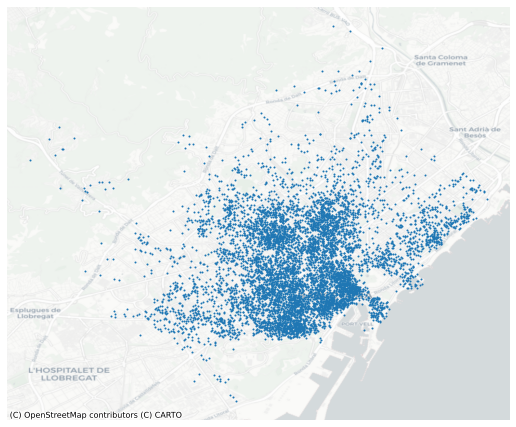

In [38]:
# Create a map of the points for Entire home/apt for 2016 data
# table
display(ab_16_pt[ab_16_pt.room_type == 'Entire home/apt'].head()) 

# map
ax = ab_16_pt[ab_16_pt.room_type == 'Entire home/apt'].plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,
                crs='epsg:4326', # surprise! You can change the crs here!
                source=ctx.providers.CartoDB.Positron)

In [ ]:
# map
ax = ab_16_pt.plot(figsize=(9,9), markersize=1, column='room_type',cmap='Oranges')

# axis
ax.axis('off')

# basemap
ctx.add_basemap(ax,
                crs='epsg:4326', # surprise! You can change the crs here!
                source=ctx.providers.CartoDB.Positron)

In [ ]:
#df = ab2016_tr[ab2016_tr.room_type == 'Entire home/apt']

df = ab_19_pt

fig = px.scatter_mapbox(df,
                        lat=df.geometry.y,
                        lon=df.geometry.x,
                        mapbox_style="carto-positron",
                        color= 'neighbourhood',
                        zoom=10
                       )
fig.show()

In [ ]:
#import plotly.express as px
#df = px.data.gapminder()

df = ab_16_pt
fig = px.scatter_mapbox(df,
                        lat=df.geometry.y,
                        lon=df.geometry.x,
                        mapbox_style="carto-positron",
                        color= 'room_type',
                        animation_frame='neighbourhood',
                        zoom=10)
fig.show()

In [ ]:
ab_barri_eh_n = ab_barri_eh.set_index('n_barri_x')
ab_barri_tot_n = ab_barri_tot.set_index('n_barri_x')
ab_barri_eh_n.head()

In [ ]:
#ab_barri_n = ab_barri.set_index('n_barri_x')

fig = px.choropleth_mapbox(ab_barri_eh_n, geojson=ab_barri_eh_n.geometry, color="bnb16_per_1000",
                           color_continuous_scale="Oranges", range_color=[0,55],
                           locations=ab_barri_eh_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb16_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2016 Airbnb Entire Apartment Counts per 1000 Dwellings',
                           opacity=0.75,
                           #animation_frame=['bnb16_per_1000','bnb17_per_1000','bnb18_per_1000','bnb19_per_1000'],
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2016_EntApt_Airbnb_per_1000.html")
fig.show()


In [ ]:
fig = px.choropleth_mapbox(ab_barri_n, geojson=ab_barri_n.geometry, color="bnb17_per_1000",
                           color_continuous_scale="Oranges", range_color=[0,55],
                           locations=ab_barri_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb17_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2017 Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2017_Airbnb_per_1000.html")
fig.show()

In [ ]:
fig = px.choropleth_mapbox(ab_barri_n, geojson=ab_barri_n.geometry, color="bnb18_per_1000",
                           color_continuous_scale="Oranges", range_color=[0,55],
                           locations=ab_barri_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb18_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2018 Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2018_Airbnb_per_1000.html")
fig.show()

In [ ]:
fig = px.choropleth_mapbox(ab_barri_n, geojson=ab_barri_n.geometry, color="bnb19_per_1000",
                           color_continuous_scale="Oranges", range_color=[0,55],
                           locations=ab_barri_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb19_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2019 Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2019_Airbnb_per_1000.html")
fig.show()

In [ ]:
# Create map for total airbnb counts per 1000 dwellings 

fig = px.choropleth_mapbox(ab_barri_tot_n, geojson=ab_barri_tot_n.geometry, color="bnb16_per_1000",
                           color_continuous_scale="Oranges", #range_color=[0,55],
                           locations=ab_barri_tot_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb16_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2016 Total Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           #animation_frame=['bnb16_per_1000','bnb17_per_1000','bnb18_per_1000','bnb19_per_1000'],
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2016_Total_Airbnb_per_1000.html")
fig.show()


In [ ]:
# Create map for total airbnb counts per 1000 dwellings 

fig = px.choropleth_mapbox(ab_barri_tot_n, geojson=ab_barri_tot_n.geometry, color="bnb17_per_1000",
                           color_continuous_scale="Oranges", #range_color=[0,55],
                           locations=ab_barri_tot_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb17_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2017 Total Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           #animation_frame=['bnb16_per_1000','bnb17_per_1000','bnb18_per_1000','bnb19_per_1000'],
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2017_Total_Airbnb_per_1000.html")
fig.show()


In [ ]:
# Create map for total airbnb counts per 1000 dwellings 

fig = px.choropleth_mapbox(ab_barri_tot_n, geojson=ab_barri_tot_n.geometry, color="bnb18_per_1000",
                           color_continuous_scale="Oranges", #range_color=[0,55],
                           locations=ab_barri_tot_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb18_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2018 Total Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           #animation_frame=['bnb16_per_1000','bnb17_per_1000','bnb18_per_1000','bnb19_per_1000'],
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2018_Total_Airbnb_per_1000.html")
fig.show()


In [ ]:
# Create map for total airbnb counts per 1000 dwellings 

fig = px.choropleth_mapbox(ab_barri_tot_n, geojson=ab_barri_tot_n.geometry, color="bnb19_per_1000",
                           color_continuous_scale="Oranges", #range_color=[0,55],
                           locations=ab_barri_tot_n.index, #featureidkey='n_barri',
                           labels={'n_barri_x':"Barri","bnb19_per_1000":"Airbnb counts per 1000 dwellings"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           title='2019 Total Airbnb Counts per 1000 Dwellings',
                           opacity=0.75,
                           #animation_frame=['bnb16_per_1000','bnb17_per_1000','bnb18_per_1000','bnb19_per_1000'],
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/Barcelona_2019_Total_Airbnb_per_1000.html")
fig.show()


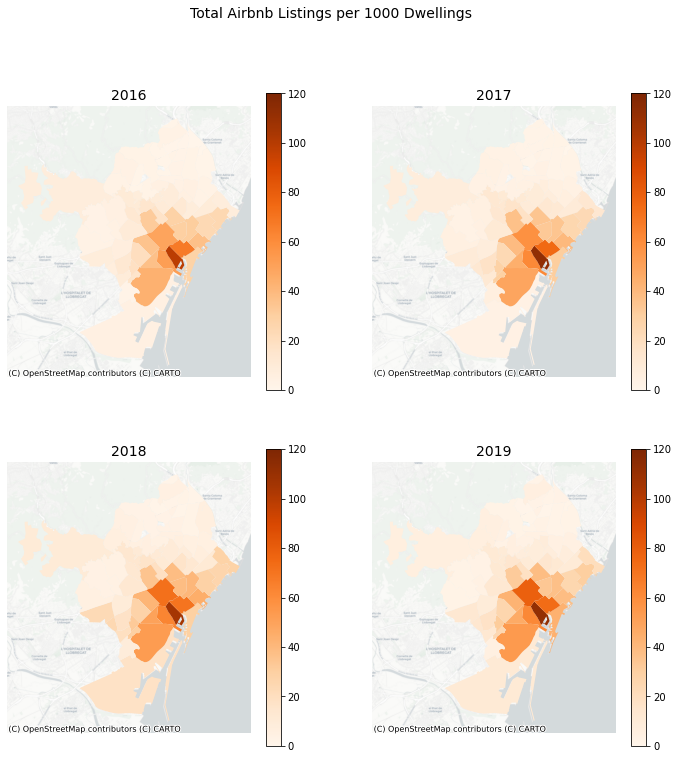

In [39]:
# Map

ab_barri_tot_web_mercator = ab_barri_tot.to_crs(epsg=3857)

fig,ax = plt.subplots(2,2,figsize=(12,12))

ab_barri_tot_web_mercator.plot(ax=ax[0,0],
         column='bnb16_per_1000',
         legend=True,vmin=0, vmax=120,
         cmap='Oranges'
        )

ax[0,0].set_title('2016', fontsize=14)
ax[0,0].axis('off');

ab_barri_tot_web_mercator.plot(ax=ax[0,1],
         column='bnb17_per_1000',
         legend=True,vmin=0, vmax=120,
         cmap='Oranges'
        )

ax[0,1].set_title('2017', fontsize=14)
ax[0,1].axis('off');

ab_barri_tot_web_mercator.plot(ax=ax[1,0],
         column='bnb18_per_1000',
         legend=True,vmin=0, vmax=120,
         cmap='Oranges'
        )

ax[1,0].set_title('2018', fontsize=14)
ax[1,0].axis('off');

ab_barri_tot_web_mercator.plot(ax=ax[1,1],
         column='bnb19_per_1000',
         legend=True,vmin=0, vmax=120,
         cmap='Oranges'
        )

ax[1,1].set_title('2019', fontsize=14)
ax[1,1].axis('off');

ctx.add_basemap(ax[0,0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[0,1],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1,0],source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax[1,1],source=ctx.providers.CartoDB.Positron) 

fig.suptitle("Total Airbnb Listings per 1000 Dwellings", fontsize=14)

plt.savefig('Output/2016-2019_Airbnb_totalper1000.png',bbox_inches='tight',transparent=True)

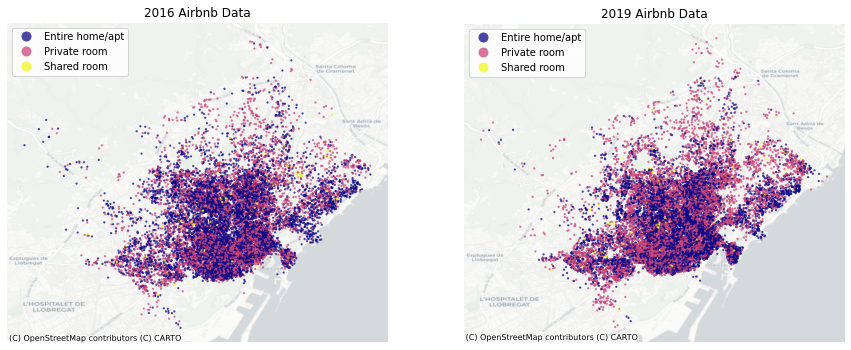

In [40]:
# create the 1x2 subplots; figure, axis; subplot with 1 row, 2 plots in row 
fig, axs = plt.subplots(1, 2, figsize=(15, 12))
# name each subplot
ax1, ax2 = axs


# map on the left
df1 = ab_16
df1.plot(column='room_type', 
            cmap='plasma', # color choice 
            edgecolor='white', 
            markersize=5,
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True)

ax1.axis("off") # turns off x and y axis numbers 
ax1.set_title("2016 Airbnb Data") # add a title to ax1
ctx.add_basemap(ax1,
                crs='epsg:4326', # surprise! You can change the crs here!
                source=ctx.providers.CartoDB.Positron)

# map on the right
df2 = ab_19
df2.plot(column='room_type', 
            cmap='plasma', # color choice 
            edgecolor='white',
            markersize=5,
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot,
            legend=True)

ax2.axis("off")
ax2.set_title("2019 Airbnb Data")
ctx.add_basemap(ax2,
                crs='epsg:4326', # surprise! You can change the crs here!
                source=ctx.providers.CartoDB.Positron)
plt.savefig('Output/Barcelona_Airbnb_Plot_2016_2019.png',bbox_inches='tight', transparent=True)

In [ ]:
# create the 1x2 subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
ab_barri.plot(ax=ax[0], # this assigns the map to the left subplot
         column='bnb16_per_1000', 
         cmap='magma', 
         #scheme='user_defined', 
         #classification_kwds={'bins':[0,5,10,15,20,25,30,35,40,45]},
         #scheme='quantiles',
         #k=5, 
         edgecolor='white',
         #legend = True,
         legend = True,
         #legend_kwds={'loc':"upper right", 'bbox_to_anchor':(3.0, 1.0), 'title':"Legend\n", 'frameon':False},
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Airbnbs per 1000 Dwellings")

# spatial lag map on the right
ab_barri.plot(ax=ax[1], # this assigns the map to the right subplot
         column='bnb17_per_1000', 
         cmap='magma',
         #scheme='user_defined', 
         #classification_kwds={'bins':[0,5,10,15,20,25,30,35,40,45]},
         #scheme='quantiles',
         #k=5, 
         legend = True,
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("Airbnbs per 1000 Dwellings")

plt.show()

## Explore Data for Hosts with Multiple Properties

Keeping this here, in case we want to explore this later.

In [ ]:
hostnum = ab_16.host_id.value_counts()
hostnum

In [ ]:
host = ab_16.query("host_id == '396363'")
host1 = ab_16.query("host_id == '10704'")
host

In [ ]:
ab_16_1 = ab_16.query("calculated_host_listings_count == '1'")
ab_16_2 = ab_16.query("calculated_host_listings_count != '1'")

In [ ]:
# map
ax = host1.plot(figsize=(9,9), markersize=1)

# axis
ax.axis('off')

ctx.add_basemap(ax,
                crs='epsg:4326', # surprise! You can change the crs here!
                source=ctx.providers.CartoDB.Positron)

## End of file

This notebook file explores point airbnb data, performs a spatial autocorrelation, and creates additional maps of the point and grouped airbnb data. 

Division of Work: We worked together to explore and clean the airbnb data. Tiffany collected total housing data per neighborhood and per year, and brought that in to combine it with the airbnb data. Casey created some exploratory maps with the airbnb data, using interactive features to be refined later. We shared responsiblity in running through the spatial autocorrelation commands. 